In [24]:
import os
import cv2
import pandas as pd


In [29]:
import numpy as np
import cv2
import torch

def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    height, width, channel = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 2
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    # dist_num = 0
    # if label == 1:
    #     dist_num = random.randint(1,3)
    # elif label == 2.5:
    #     dist_num = 2.5
    dist_num = label+1
    dist_coeffs = np.array([0, 0.03 * dist_num, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    undistorted_image = cv2.undistort(images, camera_matrix, dist_coeffs)
    undistorted_mask = cv2.undistort(masks, camera_matrix, dist_coeffs)
    undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
    undistorted_mask[undistorted_mask > 12] = 12



    return undistorted_image, undistorted_mask


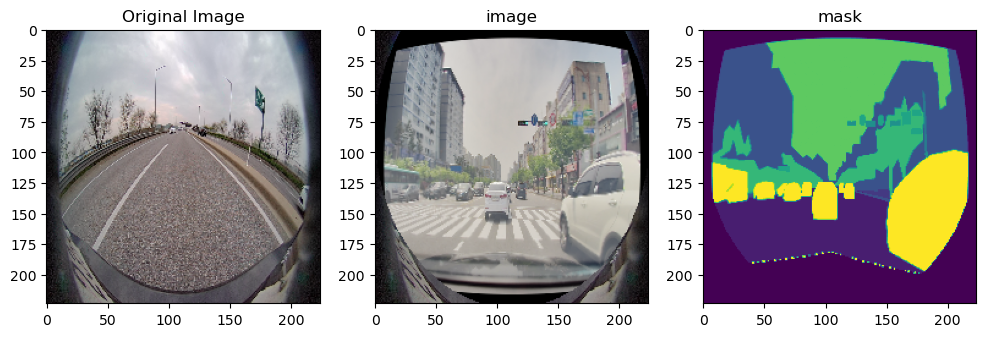

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 불러오기 (이미지 경로를 적절히 변경하세요)
target_image_path = './data/224/train_target_image/TRAIN_TARGET_0001.png'
image_path = './data/224/train_source_image/TRAIN_SOURCE_0001.png'
mask_path = './data/224/train_source_gt/TRAIN_SOURCE_0001.png'
target_image = cv2.imread(target_image_path, cv2.IMREAD_COLOR)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
ori_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
ori_source_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
ori_source_mask[ori_source_mask == 255] = 12
ori_source_mask += 1
ori_source_mask[ori_source_mask == 13] = 0

h,w,c = ori_image.shape

image, source_mask = apply_fisheye_distortion(ori_image, ori_source_mask, 2)

# 타원의 중심 좌표와 크기 설정 (예: 중심 (x, y), 장축 반지름 a, 단축 반지름 b)
center = (w//2, int(h*0.375))  # x,y
axis_length = (w//2, int(h*0.64))  # 장축 반지름과 단축 반지름

# 타원 그리기 (타원을 1로 채우고 나머지 부분은 0으로 채움)
mask = np.zeros((h,w,1),dtype=np.uint8)
cv2.ellipse(mask, center, axis_length, 0, 0, 360, 1, -1)

# 타원 모양으로 crop된 이미지 생성
mixed_image = image * mask + target_image * (1-mask)
mixed_mask = source_mask * mask[:,:,0] + np.ones_like(source_mask)*0*(1-mask[:,:,0])
mixed_mask[mixed_mask == 255] = 12
mixed_mask = mixed_mask * 20

# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(target_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mixed_image)
plt.title('image')

plt.subplot(1, 3, 3)
plt.imshow(mixed_mask)
plt.title('mask')

plt.show()
